This script contains basically all the analysis done after Delta T has been fitted, such as FF, Isc, Voc, P, polynomial fitting. It has several parts: CALCULATIONS for Isc,Voc,P, FF; PLOTTING of the same; DETERMINING the different terms of a second order polynomial (eq 1/2 in paper) as well as plotting them in different ways; FINAL PLOT used as figure 2 in manuscript is found at the very end

# Imports

In [665]:
import numpy as np
import matplotlib.pyplot  as plt
import warnings
from tqdm import tqdm
import json
import tkinter as tk
from tkinter import filedialog as fd
from ratchet_functions import *
from ratchet_functions import find_Isc_Voc # for some reason this was necesary to import this function
from ratchet_functions import Power_cut
from cProfile import label
from matplotlib.pyplot import legend
from matplotlib import cm


# Settings

In [666]:

# Figures
#plt.rcParams.update({'font.size': 15})
#plt.rcParams["font.family"] = "Arial" 

font = {'family' : 'Arial',
        'size'   : 7}

figwidth_SC_Nature = 3.45
figwidth_DC_Nature = 7

figwidth = 3.4
figheight = 3.4

#%matplotlib qt
%matplotlib inline
plot = 1
load_data = 1
load_T = 1
save_fig = 0
save_data = 0


# Parameters

In [667]:
k_B=8.617E-5 #eV
m_e = 9.11E-31 #kg
m_eff=0.023; #Effective mass InAs, in free electron mass.
h_bar = 1.05E-34 #Js
h2m = h_bar**2/(2*m_e*m_eff)*6.24E18 # [eVm^2], 6.24E18 converts from J to eV

# Load data

In [668]:

if load_data == 1:
    filename = get_file(title = 'json file for fitted data')
elif load_data== 0:
    filename = '//fysfile01/ftfhome$/jo0651fa/Documents/Lund/Projects/Ratchet barrier/Model triangular barrier/Results N2_0911_log14_15/New fits/A_1.1E5_mu_0.232/2022_09_02_A1.1E5_mu0.232_QM_fit_cut_data.json'


### fitted data ###
Jason = open(filename, 'r').read()
dictionary = json.loads(Jason)

DeltaT_G = np.array(dictionary['DeltaT_G_min'])
DeltaT_S = np.array(dictionary['DeltaT_S_min'])
V_sd_exp = np.array(dictionary['V_sd'])
V_h = np.array(dictionary['V_h'])
I_exp_G = np.array(dictionary['I_exp_G']).T
I_exp_S = np.array(dictionary['I_exp_S']).T
I_std_G = np.array(dictionary['I_std_G']).T
I_std_S = np.array(dictionary['I_std_S']).T

I_fit_G = np.array(dictionary['I_model_G']).T
I_fit_S = np.array(dictionary['I_model_S']).T

A = np.array(dictionary['Ampl'])
dE = np.array(dictionary['dE'])
mu = np.array(dictionary['mu'])
L = np.array(dictionary['L'])
U_top = np.array(dictionary['U_top'])


## Load transmission function
The file you chose must be for a voltage bias range (in +/- mV) containing the region you want to model. The files with larger range typically contain more data points so it will take longer time to calculate, no neec to choose a larger range than necesary

In [669]:
if load_T == 1:
    filename_T = get_file(title = 'json file containing calculated transmission')
elif load_T== 0:
    filename_T = '//fysfile01/ftfhome$/jo0651fa/Documents/Lund/Projects/Ratchet barrier/Model triangular barrier/Data/Transmission_20mv_340meV_92nm_dE1E-5_1000steps.json'          #Transmission_40mv_340meV_92nm.json
    
Jason_T = open(filename_T, 'r').read()
dictionary_T = json.loads(Jason_T)

E = np.array(dictionary_T['E'])
T_QM = np.array(dictionary_T['T_QM']).T
V_sd_model = np.array(dictionary_T['V_sd'])

In [670]:
#import pandas as pd
#df = pd.json_normalize(dictionary)
#savename_csv = get_savefile(title='Save as (csv)')
#df.to_csv(savename_csv+'.csv')


# Calculations

## Model current
If you want to calculate the IV for some range of temperatures in the model then do so here

In [671]:
#V_sd_model = np.linspace(-0.04, 0.04, 201)#V_sd_exp# np.linspace(-0.1, 0.1, 201)  #In case one wants a different bias range than the experiment
kDeltaT  = np.linspace(0, 25 ,100+1)*k_B  
DeltaT_model = kDeltaT/k_B
I_model_G = np.zeros((len(V_sd_model),len(kDeltaT)))
I_model_S = np.zeros((len(V_sd_model),len(kDeltaT)))

for j, DT in tqdm(enumerate(kDeltaT),position=0, leave=True):             
    for k, V in enumerate(V_sd_model):
        #for heating on source/gradient side
        f_G, f_S = fermi_dirac(mu = mu, E = E, V = V, kDeltaT_G = DT ,kDeltaT_S = 0, T = 77)
        I_model_G[k,j] = Landauer_Buttiker(T_QM[:,k], f_S, f_G, A, dE)
        #For heating on drain/steep side, swap side heated
        f_G, f_S = fermi_dirac(mu = mu, E = E, V = V, kDeltaT_G = 0 ,kDeltaT_S = DT, T = 77)
        I_model_S[k,j] = Landauer_Buttiker(T_QM[:,k], f_S, f_G, A, dE)

101it [04:30,  2.68s/it]


## Short circuit current, open-circuit voltage

In [672]:
#Source (gradient) side
Isc_exp_G, Voc_exp_G = find_Isc_Voc(I_exp_G, V_sd_exp)
Isc_std_G, Voc_std_G = find_Isc_Voc(I_exp_G+I_std_G, V_sd_exp)
Isc_std_G = abs(Isc_exp_G)-abs(Isc_std_G)#Isc_stdn_G, Voc_stdn_G = find_Isc_Voc(I_exp_G-I_std_G, V_sd_exp)
Voc_std_G = abs(Voc_exp_G)-abs(Voc_std_G)#Isc_stdn_G, Voc_stdn_G = find_Isc_Voc(I_exp_G-I_std_G, V_sd_exp)

Isc_model_G, Voc_model_G = find_Isc_Voc(I_model_G, V_sd_model)

#Drain (steep) side
Isc_exp_S, Voc_exp_S = find_Isc_Voc(I_exp_S, V_sd_exp)
Isc_std_S, Voc_std_S = find_Isc_Voc(I_exp_S+I_std_S, V_sd_exp)
Isc_std_S = abs(Isc_exp_S)-abs(Isc_std_S)#Isc_stdn_G, Voc_stdn_G = find_Isc_Voc(I_exp_G-I_std_G, V_sd_exp)
Voc_std_S = abs(Voc_exp_S)-abs(Voc_std_S)#Isc_stdn_G, Voc_stdn_G = find_Isc_Voc(I_exp_G-I_std_G, V_sd_exp)

Isc_model_S, Voc_model_S = find_Isc_Voc(I_model_S, V_sd_model)


## Power

In [673]:
# Source side
P_exp_G = Power(I_exp_G, V_sd_exp)  #Experimental data
P_fit_G = Power(I_fit_G, V_sd_exp)  #Fit between expriment and model
P_model_G = Power(I_model_G, V_sd_model)  #Calculated for choosen interval of Delta T

# Drain side
P_exp_S = Power(I_exp_S, V_sd_exp)
P_fit_S = Power(I_fit_S, V_sd_exp)
P_model_S = Power(I_model_S, V_sd_model)

#Power only within power producing quadrant
P_exp_cut_G = []
V_exp_cut_G = []
P_exp_cut_S = []
V_exp_cut_S = []
P_max_exp_G = np.zeros(len(V_h))
P_max_exp_S = np.zeros(len(V_h))
P_max_std_G = np.zeros(len(V_h))
P_max_std_S = np.zeros(len(V_h))

P_fit_cut_G = []
V_fit_cut_G = []
P_fit_cut_S = []
V_fit_cut_S = []
P_max_fit_G = np.zeros(len(V_h))
P_max_fit_S = np.zeros(len(V_h))

P_model_cut_G = []
V_model_cut_G = []
P_model_cut_S = []
V_model_cut_S = []
P_max_model_G = np.zeros(P_model_G.shape[1])
P_max_model_S = np.zeros(P_model_S.shape[1])


for i in range(len(V_h)):
#Experiemnt    
    P, V = Power_cut(I_exp_G[:,i], V_sd_exp)
    P_std, V_std = Power_cut(I_exp_G[:,i]+I_std_G[:,i], V_sd_exp)    #calculate power when adding on the standard deviation

    P_exp_cut_G.append(P)
    V_exp_cut_G.append(V)


    if P.size == 0:
        P_max_exp_G[i] = 0
        P_max_std_G[i] = 0
    else:
        P_max_exp_G[i] = np.amax(P)
        P_max_std_G[i] = np.amax(np.amax(P_std)-np.amax(P))
    
    P, V = Power_cut(I_exp_S[:,i], V_sd_exp)
    P_std, V_std = Power_cut(I_exp_S[:,i]+I_std_S[:,i], V_sd_exp)    #calculate power when adding on the standard deviation

    P_exp_cut_S.append(P)
    V_exp_cut_S.append(V)

    if P.size == 0:
        P_max_exp_S[i] = 0
        P_max_std_S[i] = 0
    else:
        P_max_exp_S[i] = np.amax(abs(P))
        P_max_std_S[i] = np.amax(np.amax(P_std)-np.amax(P))
#Fit
    P, V = Power_cut(I_fit_G[:,i], V_sd_exp)
    P_fit_cut_G.append(P)
    V_fit_cut_G.append(V)
    if P.size == 0:
        P_max_fit_G[i] = 0
    else:
        P_max_fit_G[i] = np.amax(abs(P))
    
    P, V = Power_cut(I_fit_S[:,i], V_sd_exp)
    P_fit_cut_S.append(P)
    V_fit_cut_S.append(V)
    if P.size == 0:
        P_max_fit_S[i] = 0
    else:
        P_max_fit_S[i] = np.amax(abs(P))


In [674]:
for i in range(P_model_G.shape[1]):
    #Model
        P, V = Power_cut(I_model_G[:,i], V_sd_model)
        P_model_cut_G.append(P)
        V_model_cut_G.append(V)
        if P.size == 0:
            P_max_model_G[i] = 0
        else:
            P_max_model_G[i] = np.amax(abs(P))
        
        P, V = Power_cut(I_model_S[:,i], V_sd_model)
        P_model_cut_S.append(P)
        V_model_cut_S.append(V)
        if P.size == 0:
            P_max_model_S[i] = 0
        else:
            P_max_model_S[i] = np.amax(abs(P))


## Fill factor

In [675]:
##############
### Something is wrong with the function fill_factor, it gives ~0.5 isntead of ~0.25. Being lazy, I did not fix it but just skipped using it here
# #Source (gradient) side
#FF_exp_G = fill_factor(I_exp_G, V_sd_exp)
#FF_std_G = fill_factor(I_exp_G+I_std_G, V_sd_exp)
#FF_std_G = abs(FF_exp_G)-abs(FF_std_G)

#FF_model_G = fill_factor(I_model_G, V_sd_model)
#Drain (steep) side
#FF_exp_S = fill_factor(I_exp_S, V_sd_exp)
#FF_std_S = fill_factor(I_exp_S+I_std_S, V_sd_exp)
#FF_std_S = abs(FF_exp_S)-abs(FF_std_S)
#FF_model_S = fill_factor(I_model_S, V_sd_model)
##############

### Gradient side
FF_exp_G = np.abs(P_max_exp_G/(Isc_exp_G*Voc_exp_G))
FF_model_G = np.abs(P_max_model_G/(Isc_model_G*Voc_model_G))
#Error propagation
FF_std_G = FF_exp_G*np.sqrt((P_max_std_G/P_max_exp_G)**2 + (Isc_std_G/Isc_exp_G)**2 + (Voc_std_G/Voc_exp_G)**2)

### Steep side
FF_exp_S = np.abs(P_max_exp_S/(Isc_exp_S*Voc_exp_S))
FF_model_S = np.abs(P_max_model_S/(Isc_model_S*Voc_model_S))
#Error propagation
FF_std_S = FF_exp_S*np.sqrt((P_max_std_S/P_max_exp_S)**2 + (Isc_std_S/Isc_exp_S)**2 + (Voc_std_S/Voc_exp_S)**2)



<ipython-input-675-98a9ebda55b8>:18: RuntimeWarning: invalid value encountered in true_divide
  FF_model_G = np.abs(P_max_model_G/(Isc_model_G*Voc_model_G))
<ipython-input-675-98a9ebda55b8>:24: RuntimeWarning: invalid value encountered in true_divide
  FF_model_S = np.abs(P_max_model_S/(Isc_model_S*Voc_model_S))
<ipython-input-675-98a9ebda55b8>:26: RuntimeWarning: invalid value encountered in true_divide
  FF_std_S = FF_exp_S*np.sqrt((P_max_std_S/P_max_exp_S)**2 + (Isc_std_S/Isc_exp_S)**2 + (Voc_std_S/Voc_exp_S)**2)


# Plotting


In [676]:

if save_fig == 1:

    savename_fig = get_savefile(title='Save as (no extension)')

## IV curves

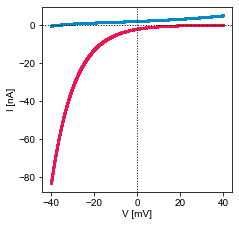

In [677]:


plot = 1

if plot == 1:

    fig_IV, ax_IV = plt.subplots()
    ax_IV.plot(V_sd_model*1E3, I_model_S[:,-1]*1E9, 'x', color = (0/255, 137/255, 207/255), ms = 2, label='Drain')
    ax_IV.plot(V_sd_model*1E3, I_model_G[:,-1]*1E9, 'x', color = (237/255, 20/255, 80/255), ms = 2, label='Source')
    vline = ax_IV.axvline(x=0, linestyle=':', color='k', linewidth = 1)
    hline = ax_IV.axhline(y=0, linestyle=':', color='k', linewidth = 1)

    ax_IV.set_xlabel('V [mV]', labelpad=2)
    ax_IV.set_ylabel('I [nA]', labelpad=2)
    fig_IV.set_size_inches(figwidth, figheight)



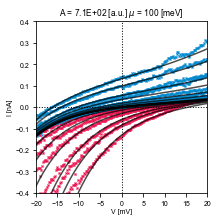

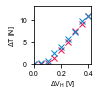

In [678]:
plt.rc('font', **font)
fig_IV, ax_IV = plt.subplots()
ax_IV.set_position([0.2, 0.15, 0.7, 0.7])    # Manually set "data frame" size: x, y, widht, height in precentage of full window
fig_IV.set_size_inches(figwidth, figheight)

ax_IV.plot(V_sd_exp*1E3, I_exp_G*1E9, 'x', color = (237/255, 20/255, 80/255), ms = 2)
ax_IV.plot(V_sd_exp*1E3, I_exp_S*1E9, 'x', color = (0/255, 137/255, 207/255), ms = 2)

ax_IV.plot(V_sd_exp*1E3, I_fit_G*1E9, 'k', alpha = 0.7)
ax_IV.plot(V_sd_exp*1E3, I_fit_S*1E9, 'k', alpha = 0.7)

vline = ax_IV.axvline(x=0, linestyle=':', color='k', linewidth = 1)
hline = ax_IV.axhline(y=0, linestyle=':', color='k', linewidth = 1)
#ax_IV.axvline(x=V_sd[start_G]*1E3,  color='k', linewidth = 1)

ax_IV.set_xlim(-20, 20)
ax_IV.set_ylim(-0.4, 0.4)

ax_IV.set_title('A = {:.1E} [a.u.] '.format(A)+'$\mu$ = {:.0f} [meV]'.format(mu*1E3))
ax_IV.set_xlabel('V [mV]', labelpad=2)
ax_IV.set_ylabel('I [nA]', labelpad=2)

### Plot T vs V_H ###
polyfit_S = np.polyfit(V_h, DeltaT_G,2)
T_G = polyfit_S[0]*V_h**2+polyfit_S[1]*V_h+polyfit_S[2]

polyfit_D = np.polyfit(V_h, DeltaT_S,2)
T_S = polyfit_D[0]*V_h**2+polyfit_D[1]*V_h+polyfit_D[2]


fig_T, ax_T = plt.subplots()
fig_T.set_size_inches(figwidth/3, figheight/3)
ax_T.set_position([0.2, 0.2, 0.7, 0.7])
ax_T.plot(V_h, DeltaT_G, 'x', color = (237/255, 20/255, 80/255))
#ax_T.plot(V_h, T_G, color = (237/255, 20/255, 80/255), alpha = 0.6, label='{:.0f}$V^2$+'.format(polyfit_S[0])+'{:.0f}$V$'.format(polyfit_S[1])+'{:.1f}'.format(polyfit_S[2]))
ax_T.plot(V_h, DeltaT_S, 'x', color = (0/255, 137/255, 207/255))
#ax_T.plot(V_h, T_S, color = (0/255, 137/255, 207/255), alpha = 0.6, label='{:.0f}$V^2$+'.format(polyfit_D[0])+'{:.0f}$V$'.format(polyfit_D[1])+'{:.1f}'.format(polyfit_D[2]))

ax_T.set_xlim(0, 0.42)
ax_T.set_ylim(0, 13)
ax_T.set_xticks([0, 0.2, 0.4])

#ax_T.legend()
ax_T.set_ylabel('$\Delta$T [N]', labelpad=2)
ax_T.set_xlabel('$\Delta$V$_\mathrm{H}$ [V]', labelpad=2)

if save_fig == 1:

    fig_IV.savefig(savename_fig+'_IV.svg')
    fig_IV.savefig(savename_fig+'_IV.png')
    fig_T.savefig(savename_fig+'_T.svg')
    fig_T.savefig(savename_fig+'_T.png')



## Short-circuit current

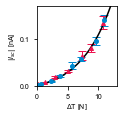

In [679]:

if plot == 1:
    plt.rc('font', **font)

    fig_Isc, ax_Isc = plt.subplots()
    ax_Isc.set_position([0.32, 0.3, 0.65, 0.65]) # Manually set "data frame" size: x, y, widht, height in precentage of full window

    ### Isc ###

    ax_Isc.errorbar(DeltaT_G, abs(Isc_exp_G*1E9), Isc_std_G*1E9, linestyle = 'none', marker = '^', ms = 4, elinewidth = 1, capsize=4, color = (237/255, 20/255, 80/255), label = 'gradient side')
    ax_Isc.errorbar(DeltaT_S, abs(Isc_exp_S*1E9), Isc_std_S*1E9, linestyle = 'none', marker = 'o', ms = 4, elinewidth = 1, capsize=4, color = (0/255, 137/255, 207/255), label = 'steep side')

    ax_Isc.plot(DeltaT_model, abs(Isc_model_G*1E9), 'k', label = 'model') 

    ax_Isc.set_xlabel('$\Delta$T [N]', labelpad=2)
    ax_Isc.set_ylabel('$|I_{sc}|$ [nA]', labelpad=2)
    ax_Isc.set_xlim(0,13)
    ax_Isc.set_xticks([0, 5, 10])
    ax_Isc.set_ylim(0, 0.17)
    ax_Isc.set_yticks([0, 0.1])

    fig_Isc.set_size_inches(figwidth/2, figheight/2)
    #fig_Isc.legend()


if save_fig == 1:

    fig_Isc.savefig(savename_fig+'_Isc.svg')
    fig_Isc.savefig(savename_fig+'_Isc.png')




## Open-circuit voltage

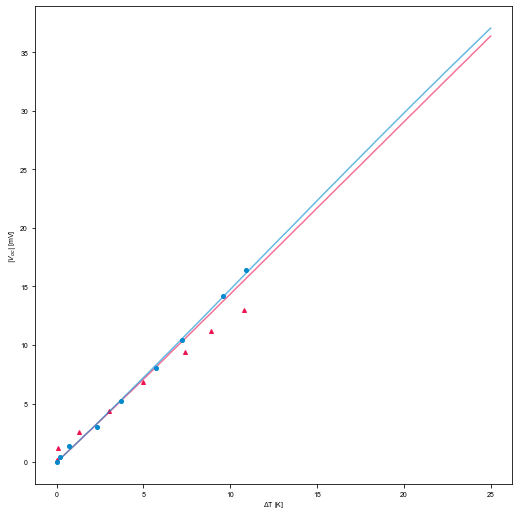

In [680]:


if plot == 1:
    plt.rc('font', **font)          
    fig_Voc, ax_Voc = plt.subplots()
    ax_Voc.set_position([0.3, 0.3, 0.65, 0.65]) # Manually set "data frame" size: x, y, widht, height in precentage of full window

    ### Voc ###

    ax_Voc.plot(DeltaT_G, abs(Voc_exp_G*1E3), '^', ms=4, color = (237/255, 20/255, 80/255), label = 'gradient side')
    ax_Voc.plot(DeltaT_model, abs(Voc_model_G*1E3), color = (237/255, 20/255, 80/255), alpha = 0.6, label = 'model') 
    ax_Voc.plot(DeltaT_S, abs(Voc_exp_S*1E3), 'o', ms=4, color = (0/255, 137/255, 207/255), label = 'steep side')
    ax_Voc.plot(DeltaT_model, abs(Voc_model_S*1E3), color = (0/255, 137/255, 207/255), alpha = 0.6, label = 'model') 

   # ax_Voc.set_xlim(0,15)
    #ax_Voc.set_xticks([0, 5, 10, 15])
   # ax_Voc.set_ylim(0, 20)
    ax_Voc.set_xlabel('$\Delta$T [K]', labelpad=2)
    ax_Voc.set_ylabel('$|V_{oc}|$ [mV]', labelpad=2)

    fig_Voc.set_size_inches(figwidth*3, figheight*3)
    #fig_Voc.legend(loc='upper left')

if save_fig == 1:

    fig_Voc.savefig(savename_fig+'_Voc.svg')
    fig_Voc.savefig(savename_fig+'_Voc.png')

In [681]:
#np.savetxt('dT_model.txt', DeltaT_model)
#np.savetxt('Voc_model_L.txt', Voc_model_G)
#np.savetxt('Voc_model_R.txt', Voc_model_S)



## Power

Power in full range, just as product of I and V

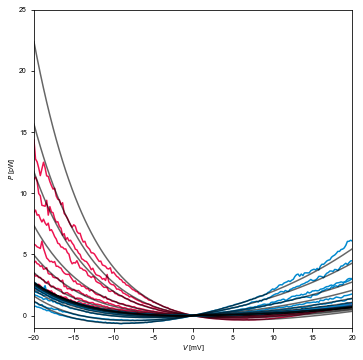

In [682]:


if plot == 1:
    plt.rc('font', **font)    
    fig_P, ax_P = plt.subplots()
    ax_P.set_position([0.2, 0.2, 0.65, 0.65]) # Manually set "data frame" size: x, y, widht, height in precentage of full window

    ax_P.plot(V_sd_exp*1E3, P_exp_G*1E12, color = (237/255, 20/255, 80/255), ms = 7, label = 'exp. gradient side')
    ax_P.plot(V_sd_exp*1E3, P_fit_G*1E12, 'k', alpha = 0.6, label = 'model gradient side')
    ax_P.plot(V_sd_exp*1E3, P_exp_S*1E12,  color = (0/255, 137/255, 207/255), ms = 7, label = 'exp. steep side')
    ax_P.plot(V_sd_exp*1E3, P_fit_S*1E12, 'k', alpha = 0.6, label = 'model steep side')

    ax_P.set_xlabel('$V$ [mV]', labelpad=2)
    ax_P.set_ylabel('$P$ [pW]', labelpad=2)
    ax_P.set_xlim(-20,20)
    ax_P.set_ylim(-1,25)

    fig_P.set_size_inches(figwidth*2, figheight*2)


if save_fig == 1:

    fig_P.savefig(savename_fig+'_P.svg')
    fig_P.savefig(savename_fig+'_P.png')

Power only in the power producing quadrant, absolute value

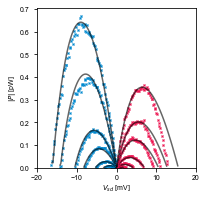

In [683]:
if plot == 1:
    plt.rc('font', **font)   
    fig_pc, ax_pc = plt.subplots()
    ax_pc.set_position([0.2, 0.2, 0.65, 0.65]) # Manually set "data frame" size: x, y, widht, height in precentage of full window
    for i in range(len(V_h)):
            
        ax_pc.plot(V_exp_cut_G[i]*1E3, P_exp_cut_G[i]*1E12,'x',ms=2, color = (237/255, 20/255, 80/255), label = 'gradient side')
        ax_pc.plot(-V_exp_cut_S[i]*1E3, P_exp_cut_S[i]*1E12,'x',ms=2,  color = (0/255, 137/255, 207/255), label = 'steep side')

        #Plot standard deviation
        #common_index_G = np.nonzero(np.in1d(V_exp_cut_G[i], V_exp_cut_G_std[i]))[0]
        #common_index_S = np.nonzero(np.in1d(V_exp_cut_S[i], V_exp_cut_S_std[i]))[0]


        #plt.fill_between(V_exp_cut_G_std[i]*1E3, (P_exp_cut_G[i][common_index_G]+P_exp_cut_G_std[i])*1E12, (P_exp_cut_G[i][common_index_G]-P_exp_cut_G_std[i])*1E12, color = (237/255, 20/255, 80/255), alpha=0.4) 
        #plt.fill_between(V_exp_cut_S_std[i]*1E3, (P_exp_cut_S[i][common_index_S]+P_exp_cut_S_std[i])*1E12, (P_exp_cut_S[i][common_index_S]-P_exp_cut_S_std[i])*1E12, color = (237/255, 20/255, 80/255), alpha=0.4) 

        ax_pc.plot(V_fit_cut_G[i]*1E3, P_fit_cut_G[i]*1E12, 'k', alpha = 0.6, label = 'fit gradient side')
        ax_pc.plot(-V_fit_cut_S[i]*1E3, P_fit_cut_S[i]*1E12,  'k', alpha = 0.6, label = 'fit steep side')
        
        #if P_exp_cut_G[i].size != 1:
        #    ax_pc.plot(V_exp_cut_G[i][find_nearest(abs(P_exp_cut_G[i]), P_max_exp_G[i])]*1E3, P_max_exp_G[i]*1E12,  'xk')
        #    ax_pc.plot(-V_exp_cut_S[i][find_nearest(abs(P_exp_cut_S[i]), P_max_exp_S[i])]*1E3, P_max_exp_S[i]*1E12,  'xk')

    
    ax_pc.set_xlabel('$V_{sd}$ [mV]', labelpad=2)
    ax_pc.set_ylabel('$|P|$ [pW]', labelpad=2)
    ax_pc.set_xlim(-20, 20)
    ax_pc.set_ylim(0)
    fig_pc.set_size_inches(figwidth, figheight)


if save_fig == 1:
    fig_pc.savefig(savename_fig+'_Pabs.svg')
    fig_pc.savefig(savename_fig+'_Pabs.png')


Make a polynomial fit to data in order to extract Pmax

In [684]:
P_cut_poly_G=[]
P_cut_poly_S=[]
V_cut_poly_G=[]
V_cut_poly_S=[]

P_max_poly_G = np.zeros(len(V_h))
P_max_poly_S = np.zeros(len(V_h))

P_poly_SSD_G = np.zeros(len(V_h))
P_poly_SSD_S = np.zeros(len(V_h))
for i in range(len(V_h)):
    if len(P_exp_cut_G[i])<5:
        P_cut_poly_G.append(np.array([0]))
        P_cut_poly_S.append(np.array([0]))
        V_cut_poly_G.append(np.array([0]))
        V_cut_poly_S.append(np.array([0]))
    elif len(P_exp_cut_S[i])<5:
        P_cut_poly_G.append(np.array([0]))
        P_cut_poly_S.append(np.array([0]))
        V_cut_poly_G.append(np.array([0]))
        V_cut_poly_S.append(np.array([0]))
    else:
        A_G, B_G, C_G = np.polyfit(V_exp_cut_G[i],P_exp_cut_G[i], 2)
        Poly_G = V_exp_cut_G[i]**2*A_G+V_exp_cut_G[i]*B_G+C_G
        P_cut_poly_G.append(Poly_G)
        V_cut_poly_G.append(V_exp_cut_G[i])
        P_max_poly_G[i] = np.amax(Poly_G) 
        
        P_poly_SSD_G[i] = np.sum(np.square(Poly_G - P_exp_cut_G[i]))
        
        A_S, B_S, C_S = np.polyfit(V_exp_cut_S[i],P_exp_cut_S[i], 2)
        Poly_S = V_exp_cut_S[i]**2*A_S+V_exp_cut_S[i]*B_S+C_S
        P_cut_poly_S.append(Poly_S)
        V_cut_poly_S.append(V_exp_cut_S[i])
        P_max_poly_S[i]=np.amax(Poly_S)
        P_poly_SSD_S[i] = np.sum(np.square(Poly_S - P_exp_cut_S[i]))



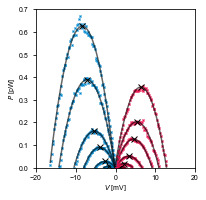

In [685]:
if plot == 1:
    plt.rc('font', **font)   
    fig_pc, ax_pc = plt.subplots()
    ax_pc.set_position([0.2, 0.2, 0.65, 0.65]) # Manually set "data frame" size: x, y, widht, height in precentage of full window
    for i in range(len(V_h)):
            
        ax_pc.plot(V_exp_cut_G[i]*1E3, P_exp_cut_G[i]*1E12,'x',ms=2, color = (237/255, 20/255, 80/255), label = 'gradient side')
        ax_pc.plot(-V_exp_cut_S[i]*1E3, P_exp_cut_S[i]*1E12,'x',ms=2,  color = (0/255, 137/255, 207/255), label = 'steep side')

        ax_pc.plot(V_cut_poly_G[i]*1E3, P_cut_poly_G[i]*1E12, 'k', alpha = 0.6, label = 'poly gradient side')
        ax_pc.plot(-V_cut_poly_S[i]*1E3, P_cut_poly_S[i]*1E12,  'k', alpha = 0.6, label = 'poly steep side')
        
        if P_cut_poly_G[i].size != 1:
            ax_pc.plot(V_cut_poly_G[i][find_nearest(abs(P_cut_poly_G[i]), P_max_poly_G[i])]*1E3, P_max_poly_G[i]*1E12,  'xk')
            ax_pc.plot(-V_exp_cut_S[i][find_nearest(abs(P_cut_poly_S[i]), P_max_poly_S[i])]*1E3, P_max_poly_S[i]*1E12,  'xk')

    
    ax_pc.set_xlabel('$V$ [mV]', labelpad=2)
    ax_pc.set_ylabel('$P$ [pW]', labelpad=2)
    ax_pc.set_xlim(-20, 20)
    ax_pc.set_ylim(0)
    fig_pc.set_size_inches(figwidth, figheight)

if save_fig == 1:
    fig_pc.savefig(savename_fig+'_Pabs_poly.svg')
    fig_pc.savefig(savename_fig+'_Pabs_poly.png')

maximum power in power producing region

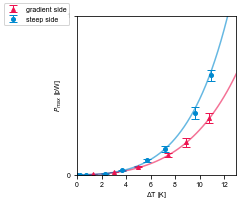

In [686]:


if plot == 1:
    plt.rc('font', **font)
    fig_Pmax, ax_Pmax = plt.subplots()
    ax_Pmax.set_position([0.3, 0.3, 0.65, 0.65]) # Manually set "data frame" size: x, y, widht, height in precentage of full window


    ax_Pmax.errorbar(DeltaT_G, P_max_poly_G*1E12, P_max_std_G*1E12, linestyle = 'none', marker = '^', ms = 4, elinewidth = 1, capsize=4, color = (237/255, 20/255, 80/255), label = 'gradient side')
    ax_Pmax.errorbar(DeltaT_S, P_max_poly_S*1E12, P_max_std_S*1E12, linestyle = 'none', marker = 'o', ms = 4, elinewidth = 1, capsize=4, color = (0/255, 137/255, 207/255), label = 'steep side')


    ax_Pmax.plot(DeltaT_model, P_max_model_G*1E12, color = (237/255, 20/255, 80/255), alpha = 0.6)
    ax_Pmax.plot(DeltaT_model, P_max_model_S*1E12, color = (0/255, 137/255, 207/255), alpha = 0.6)

    ax_Pmax.set_xlabel('$\Delta$T [K]', labelpad=2)
    ax_Pmax.set_ylabel('$P_{max}$ [pW]', labelpad=2)

    ax_Pmax.set_xlim(0,13)
    #ax_Pmax.set_xticks([0,5,10,15])
    ax_Pmax.set_ylim(0, 1)
    ax_Pmax.set_yticks([0, 1])

    fig_Pmax.set_size_inches(figwidth, figheight)
    fig_Pmax.legend(loc='upper left')


if save_fig == 1:
    #savename_fig = '//fysfile01/ftfhome$/jo0651fa/Documents/Lund/Projects/Ratchet barrier/Model triangular barrier/Results N2_0911_log14_15/New fits/L92nm_Utop_340meV/A_2.0E3_mu_93meV/A_2.0E3_mu_93meV'
    fig_Pmax.savefig(savename_fig+'_Pmax.svg')
    fig_Pmax.savefig(savename_fig+'_Pmax.png')

## Fill factor

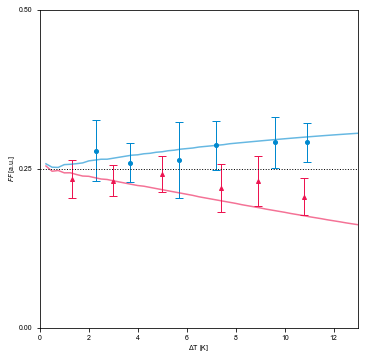

In [593]:
if plot == 1:
    plt.rc('font', **font)   
    fig_FF, ax_FF = plt.subplots()
    ax_FF.set_position([0.3, 0.3, 0.65, 0.65]) # Manually set "data frame" size: x, y, widht, height in precentage of full window

    ax_FF.errorbar(DeltaT_G[3:], FF_exp_G[3:], FF_std_G[3:], linestyle = 'none', marker = '^', ms = 4, elinewidth = 1, capsize=4, color = (237/255, 20/255, 80/255), label = 'gradient side')
    ax_FF.errorbar(DeltaT_S[3:], FF_exp_S[3:], FF_std_S[3:], linestyle = 'none', marker = 'o', ms = 4, elinewidth = 1, capsize=4, color = (0/255, 137/255, 207/255), label = 'steep side')

    #ax_FF.plot(DeltaT_G[3:], FF_exp_G[3:], 'x', color = (237/255, 20/255, 80/255), ms = 7, label = 'exp. gradient side')
    ax_FF.plot(DeltaT_model, FF_model_G, color = (237/255, 20/255, 80/255), alpha = 0.6, label = 'model gradient side')
    #ax_FF.plot(DeltaT_S[3:], FF_exp_S[3:], 'x',  color = (0/255, 137/255, 207/255), ms = 7, label = 'exp. steep side')
    ax_FF.plot(DeltaT_model, FF_model_S, color = (0/255, 137/255, 207/255), alpha = 0.6, label = 'model steep side')

    hline = ax_FF.axhline(y=0.25, linestyle=':', color='k', linewidth = 1)

    ax_FF.set_xlabel('$\Delta$T [K]', labelpad=2)
    ax_FF.set_ylabel('$FF$ [a.u.]', labelpad=2)
    ax_FF.set_xlim(0, 13)
    ax_FF.set_ylim(0, 0.5)
    ax_FF.set_yticks([0, 0.25, 0.5])
    fig_FF.set_size_inches(figwidth*2, figheight*2)
    #fig_FF.legend(loc='center right')


if save_fig == 1:

    fig_FF.savefig(savename_fig+'_FF.svg')
    fig_FF.savefig(savename_fig+'_FF.png')

## Save Data

In [ ]:

    
if save_data == 1:

    savename_data = get_savefile(title='Save data as json')

    data = {
    "DeltaT_G":DeltaT_G.tolist(),
    "DeltaT_S":DeltaT_S.tolist(),
    "DeltaT_model":DeltaT_model.tolist(),
    "FF_exp_G":FF_exp_G.tolist(),
    "FF_exp_S":FF_exp_S.tolist(),
    "FF_model_G":FF_model_G.tolist(),
    "FF_model_S":FF_model_S.tolist(),
    "P_max_exp_G":P_max_exp_G.tolist(),
    "P_max_exp_S":P_max_exp_S.tolist(),
    "P_max_model_G":P_max_model_G.tolist(),
    "P_max_model_S":P_max_model_S.tolist(),
    "I_sc_exp_G":Isc_exp_G.tolist(),
    "I_sc_exp_S":Isc_exp_S.tolist(),
    "I_sc_model_G":Isc_model_G.tolist(),
    "I_sc_model_S":Isc_model_S.tolist(),   
    "V_oc_exp_G":Voc_exp_G.tolist(),
    "V_oc_exp_S":Voc_exp_S.tolist(),
    "V_oc_model_G":Voc_model_G.tolist(),
    "V_oc_model_S":Voc_model_S.tolist()

    }
    json.dump(data, open(savename_data, 'w'))
    
 

# Finding the coefficients I = GV + LT + MV^2 + NT^2 + HVT

## Linnear fit in small bias region

In [687]:
x = 10   #+/- number of data points around Vsd=0 to do linear fit
center = find_nearest(V_sd_exp, 0)
start_lin = center - x
stop_lin = center + x

V = V_sd_exp[start_lin:stop_lin] #Small range voltage bias
I_G = I_exp_G[start_lin:stop_lin]
I_S = I_exp_S[start_lin:stop_lin]

#for storing coeficient from 1D poly fit
k_G = np.zeros(len(V_h))  
k_S = np.zeros(len(V_h))
m_G = np.zeros(len(V_h))
m_S = np.zeros(len(V_h))

for i in range(len(V_h)):
    k_G[i], m_G[i] = np.polyfit(V, I_G[:,i], 1)
    k_S[i], m_S[i] = np.polyfit(V, I_S[:,i], 1)
    



Plot


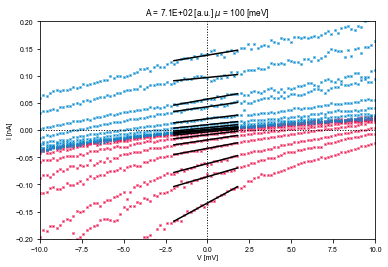

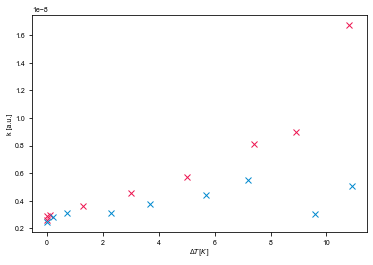

In [688]:
fig, ax = plt.subplots()

ax.plot(V_sd_exp*1E3, I_exp_G*1E9, 'x', color = (237/255, 20/255, 80/255), ms = 2)
ax.plot(V_sd_exp*1E3, I_exp_S*1E9, 'x', color = (0/255, 137/255, 207/255), ms = 2)

for i in range(len(V_h)):
    ax.plot(V*1E3, (V*k_G[i]+m_G[i])*1E9, 'k')
    ax.plot(V*1E3, (V*k_S[i]+m_S[i])*1E9, 'k')

vline = ax.axvline(x=0, linestyle=':', color='k', linewidth = 1)
hline = ax.axhline(y=0, linestyle=':', color='k', linewidth = 1)

ax.set_xlim(-10, 10)
ax.set_ylim(-0.2, 0.2)

ax.set_title('A = {:.1E} [a.u.] '.format(A)+'$\mu$ = {:.0f} [meV]'.format(mu*1E3))
ax.set_xlabel('V [mV]', labelpad=2)
ax.set_ylabel('I [nA]', labelpad=2)

fig2, ax2 = plt.subplots()

ax2.plot(DeltaT_G, k_G, 'x', color = (237/255, 20/255, 80/255))
ax2.plot(DeltaT_S, k_S, 'x', color = (0/255, 137/255, 207/255))

ax2.set_xlabel('$\Delta T [K]$', labelpad=2)
ax2.set_ylabel('k [a.u.]', labelpad=2)



if save_fig == 1:


    fig.savefig(savename_fig+'_lin_fit.svg')
    fig.savefig(savename_fig+'_lin_fit.png')

    #savename_fig2 = get_savefile(title='Save Temp dependence as (no extension)')
    #fig2.savefig(savename_fig+'_lin_fit_slopes.svg')
    #fig2.savefig(savename_fig+'_lin_fit_slopes.png')


In [689]:
V

array([-2.000000e-03, -1.800000e-03, -1.600000e-03, -1.400000e-03,
       -1.200000e-03, -1.000000e-03, -8.000000e-04, -6.000000e-04,
       -4.000000e-04, -2.000001e-04, -5.820766e-11,  1.999999e-04,
        3.999999e-04,  5.999999e-04,  7.999999e-04,  9.999999e-04,
        1.200000e-03,  1.400000e-03,  1.600000e-03,  1.800000e-03])

## G

In [690]:
### Conductance from the small bias slope of the two dark kurves
G = (k_G[0]+k_S[0])/2

G_std = np.std([k_G[0], k_S[0]])


## H

Since k= G + H*DT, a 1D polynomial is fitted with G fixed to extract H

In [691]:

# p_G = np.polyfit(DeltaT_G, k_G, 1)
# p_S = np.polyfit(DeltaT_S, k_S, 1)

# #Gradient side
# x = DeltaT_G
# y = k_G
# #XX = np.column_stack((x ** 2, x, np.ones_like(x))), This would yield the same resylt as np.polyfit()
# Eq = np.column_stack((x ** 2, x))  # here the equation is modified so that m=0

# p_G, _, _, _  = np.linalg.lstsq(Eq, y)    #skip the other parameters dunno what they are, the first one contains an array of the coefficients, from highest order down
# I_poly_G = p_G[0]*V_sd_exp**3+p_G[1]*V_sd_exp**2+p_G[2]*V_sd_exp

# H_G = p_G[0]
# H_S = p_S[0]



In [692]:
from scipy.optimize import curve_fit
def func_1d(x, g, h):  # a 1D polynomial
  return g + h * x 

#Gradient side
popt_cons, _ = curve_fit(func_1d, DeltaT_G, k_G, bounds=([G,-np.inf], [G+G/1E5,np.inf]))    #Polynomial fit where g is forced to the value G found before
H_G = popt_cons[1]

#Steep side
popt_cons, _ = curve_fit(func_1d, DeltaT_S, k_S, bounds=([G,-np.inf], [G+G/1E5,np.inf])) 
H_S = popt_cons[1]


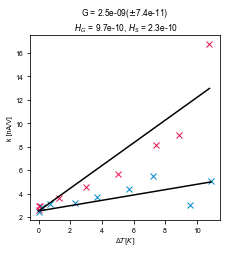

In [693]:
fig, ax = plt.subplots()
fig.set_size_inches(figwidth, figheight)

ax.plot(DeltaT_G, k_G*1E9, 'x', color = (237/255, 20/255, 80/255))
ax.plot(DeltaT_S, k_S*1E9, 'x', color = (0/255, 137/255, 207/255))
ax.plot(DeltaT_G, G*1E9 + DeltaT_G*H_G*1E9, 'k')
ax.plot(DeltaT_S, G*1E9 + DeltaT_S*H_S*1E9, 'k')


ax.set_xlabel('$\Delta T [K]$', labelpad=2)
ax.set_ylabel('k [nA/V]', labelpad=2)

ax.set_title('G = {:.1e}'.format(G) +'($\pm${:.1e})'.format(G_std) + '\n $H_G$ = {:.1e}'.format(H_G) + ', $H_S$ = {:.1e}'.format(H_S) )



if save_fig == 1:

    fig.savefig(savename_fig+'_lin_fit_slopes.svg')
    fig.savefig(savename_fig+'_lin_fit_slopes.png')

## L

By Siebeck coefficient from paper.
0=GVoc+LDT --> L=-G(Voc/DT)=-GS 
S= 1.5 mv/K

In [694]:
L_seebeck = 1.5*10E-3
print(L_seebeck)

0.015


## L & N

Extract both by a 2D polyfit to Isc

In [695]:
from scipy.optimize import curve_fit
def func_2d(x, b, c):  # a 1D polynomial
  return b*x  + c*x**2

#Gradient side

#P_G, _ = curve_fit(func_2d, DeltaT_G, Isc_exp_G, bounds=([-L_seebeck,-np.inf], [-L_seebeck+L_seebeck/1E5,np.inf]))    #Polynomial fit where g is forced to the value G found before
P_G, _ = curve_fit(func_2d, DeltaT_G, Isc_exp_G)    #Polynomial fit where g is forced to the value G found before
L_G = P_G[0]
N_G = P_G[1]
Isc_poly_G = (L_G*DeltaT_G + N_G*DeltaT_G**2)

#Steep side
#P_S, _ = curve_fit(func_2d, DeltaT_S, Isc_exp_S, bounds=([L_seebeck,-np.inf], [L_seebeck+L_seebeck/1E5,np.inf]))    #Polynomial fit where g is forced to the value G found before
P_S, _ = curve_fit(func_2d, DeltaT_S, Isc_exp_S)    #Polynomial fit where g is forced to the value G found before
L_S = P_S[0]
N_S = P_S[1]
Isc_poly_S = (L_S*DeltaT_S + N_S*DeltaT_S**2)

L_array = np.abs(np.array([L_G,L_S]))
L = np.average(L_array)
L_std = np.std(L_array)

N_array = np.abs(np.array([N_G,N_S]))
N = np.average(N_array)
N_std = np.std(N_array)



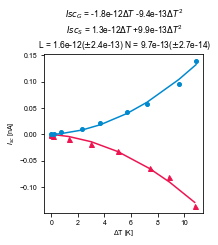

In [696]:

          
fig, ax = plt.subplots()
ax.set_position([0.32, 0.3, 0.65, 0.65]) # Manually set "data frame" size: x, y, widht, height in precentage of full window

ax.plot(DeltaT_G, Isc_exp_G*1E9, linestyle = 'none', marker = '^', ms = 5, color = (237/255, 20/255, 80/255)) 
ax.plot(DeltaT_G, Isc_poly_G*1E9, color = (237/255, 20/255, 80/255)) 

ax.plot(DeltaT_S, Isc_exp_S*1E9, linestyle = 'none', marker = 'o', ms = 4, color = (0/255, 137/255, 207/255)) 
ax.plot(DeltaT_S, Isc_poly_S*1E9, color = (0/255, 137/255, 207/255)) 


ax.set_xlabel('$\Delta$T [K]', labelpad=2)
ax.set_ylabel('$I_{sc}$ [nA]', labelpad=2)


ax.set_title('$Isc_G$ = {:.1e}$\Delta T$ '.format(L_G)+ '{:.1e}$\Delta T^2$'.format(N_G) + 
'\n $Isc_S$ = {:.1e}$\Delta T$ '.format(L_S)+ '+{:.1e}$\Delta T^2$'.format(N_S)
+ '\n L = {:.1e}'.format(L) +'($\pm${:.1e})'.format(L_std)+ ' N = {:.1e}'.format(N) +'($\pm${:.1e})'.format(N_std))

fig.set_size_inches(figwidth, figheight)



if save_fig == 1:

    fig.savefig(savename_fig+'_Isc_polyfit.svg')
    fig.savefig(savename_fig+'_Isc_polyfit..png')



Extracting N by means of asymmetry

Text(0.5, 1.0, 'Steep side')

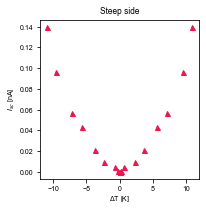

In [697]:
Isc_exp_S_conc =np.concatenate((Isc_exp_S[::-1], Isc_exp_S))
DeltaT_S_conc = np.concatenate((-DeltaT_S[::-1], DeltaT_S))

fig, ax = plt.subplots()
ax.set_position([0.32, 0.3, 0.65, 0.65]) # Manually set "data frame" size: x, y, widht, height in precentage of full window
fig.set_size_inches(figwidth, figheight)

ax.plot(DeltaT_S_conc, Isc_exp_S_conc*1E9, linestyle = 'none', marker = '^', ms = 5, color = (237/255, 20/255, 80/255))
#ax.plot(DeltaT_S, Isc_exp_S[::-1]*1E9, linestyle = 'none', marker = '^', ms = 5, color = (237/255, 20/255, 80/255))  

ax.set_xlabel('$\Delta$T [K]', labelpad=2)
ax.set_ylabel('$I_{sc}$ [nA]', labelpad=2)
ax.set_title('Steep side')

In [698]:


#Steep side
#P_S, _ = curve_fit(func_2d, DeltaT_S, Isc_exp_S, bounds=([L_seebeck,-np.inf], [L_seebeck+L_seebeck/1E5,np.inf]))    #Polynomial fit where g is forced to the value G found before
P_S, _ = curve_fit(func_2d, DeltaT_S, Isc_exp_S)    #Polynomial fit where g is forced to the value G found before
L_S = P_S[0]
N_S = P_S[1]
Isc_poly_S = (L_S*DeltaT_S + N_S*DeltaT_S**2)




## M

By doing a 3rd order polyfit to the IV curve without heating applied

In [699]:
from scipy.optimize import curve_fit
def func_3d(x, b, c, d):  # a 1D polynomial
  return  b*x  + c*x**2 + d*x**3

#Gradient side
#P_G, _ = curve_fit(func_3d, V_sd_exp, I_exp_G[:,0], bounds=([G,-np.inf,-np.inf], [G+G/1E4,np.inf,np.inf]))    #3rd orderpolynomial fit where g is forced to the value G found before
P_G, _ = curve_fit(func_2d, V_sd_exp, I_exp_G[:,0], bounds=([G,-np.inf], [G+G/1E4,np.inf]))    #2nd order polynomial fit where g is forced to the value G found before

M_G = P_G[1]

#I_poly_G = G*V_sd_exp + M_G*V_sd_exp**2 + P_G[2]*V_sd_exp**3   #3rd order
I_poly_G = G*V_sd_exp + M_G*V_sd_exp**2     #2nd order


#Steep side

#P_S, _ = curve_fit(func_3d, V_sd_exp, I_exp_S[:,0], bounds=([G,-np.inf,-np.inf], [G+G/1E4,np.inf,np.inf]))    #Polynomial fit where g is forced to the value G found before
P_S, _ = curve_fit(func_2d, V_sd_exp, I_exp_S[:,0], bounds=([G,-np.inf], [G+G/1E4,np.inf]))    #2nd order polynomial fit where g is forced to the value G found before

M_S = P_S[1]

#I_poly_S= G*V_sd_exp + M_S*V_sd_exp**2 + P_S[2]*V_sd_exp**3    #3rd order
I_poly_S = G*V_sd_exp + M_S*V_sd_exp**2     #2nd order


M_array = np.abs(np.array([M_G, M_S]))
M = np.average(M_array)
M_std = np.std(M_array)



Plot

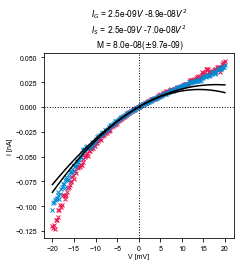

In [700]:
fig, ax = plt.subplots()
fig.set_size_inches(figwidth, figheight)
#data
ax.plot(V_sd_exp*1E3, I_exp_G[:,0]*1E9, 'x', color = (237/255, 20/255, 80/255), ms = 4)
ax.plot(V_sd_exp*1E3, I_exp_S[:,0]*1E9, 'x', color = (0/255, 137/255, 207/255), ms = 4)
#polyfit
ax.plot(V_sd_exp*1E3, I_poly_G*1E9, 'k')
ax.plot(V_sd_exp*1E3, I_poly_S*1E9, 'k')

vline = ax.axvline(x=0, linestyle=':', color='k', linewidth = 1)
hline = ax.axhline(y=0, linestyle=':', color='k', linewidth = 1)



ax.set_title('$I_G$ = {:.1e}$V$ '.format(G) + '{:.1e}$V^2$'.format(M_G) +
'\n' + '$I_S$ = {:.1e}$V$ '.format(G) + '{:.1e}$V^2$'.format(M_S) 
+ '\n M = {:.1e}'.format(M) +'($\pm${:.1e})'.format(M_std))
        #+' + {:.1e}$V^3$'.format(P_G[2])
        #+' + {:.1e}$V^3$'.format(P_S[2]
ax.set_xlabel('V [mV]', labelpad=2)
ax.set_ylabel('I [nA]', labelpad=2)



if save_fig == 1:

    fig.savefig(savename_fig+'_dark_IV_2dpolyfit.svg')
    fig.savefig(savename_fig+'_dark_IV_2dpolyfit.png')

extracting M by plotting only the asymmetric part of the IV curves

In [701]:
from scipy.optimize import curve_fit
def func_parabola(x, c):  # a polynomial with only the second order term
  return  c*x**2


#Steep side 
I_exp_S_rev = I_exp_S[:,0][::-1]
I_asym_S = 1/2*(I_exp_S[:,0]+I_exp_S_rev)
P_S, _ = curve_fit(func_parabola, V_sd_exp, I_asym_S)    #polynomial fit 
M_S = P_S[0]

I_parabola_S = M_S*V_sd_exp**2     #2nd order

#Gradient side
I_exp_G_rev = I_exp_G[:,0][::-1]
I_asym_G = 1/2*(I_exp_G[:,0]+I_exp_G_rev)
P_G, _ = curve_fit(func_parabola, V_sd_exp, I_asym_G)    #polynomial fit 
M_G = P_G[0]

I_parabola_G = M_G*V_sd_exp**2     #2nd order






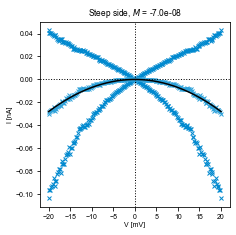

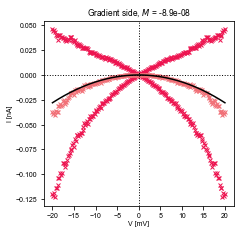

In [702]:
#steep side
fig_S, ax_S = plt.subplots()
fig_S.set_size_inches(figwidth, figheight)
#data
ax_S.plot(V_sd_exp*1E3, I_exp_S[:,0]*1E9, 'x', color = (0/255, 137/255, 207/255), ms = 4)
ax_S.plot(V_sd_exp*1E3, I_exp_S_rev*1E9, 'x', color = (0/255, 137/255, 207/255), ms = 4)
ax_S.plot(V_sd_exp*1E3, I_asym_S*1E9, 'x', color = (44/255, 161/255, 218/255), ms = 4)
#polyfit
ax_S.plot(V_sd_exp*1E3, I_parabola_S*1E9, 'k')

vline = ax_S.axvline(x=0, linestyle=':', color='k', linewidth = 1)
hline = ax_S.axhline(y=0, linestyle=':', color='k', linewidth = 1)

ax_S.set_title('Steep side, $M$ = {:.1e}'.format(M_S))
ax_S.set_xlabel('V [mV]', labelpad=2)
ax_S.set_ylabel('I [nA]', labelpad=2)

#Gradient side
fig_G, ax_G = plt.subplots()
fig_G.set_size_inches(figwidth, figheight)
#data
ax_G.plot(V_sd_exp*1E3, I_exp_G[:,0]*1E9, 'x', color = (237/255, 20/255, 80/255), ms = 4)
ax_G.plot(V_sd_exp*1E3, I_exp_G_rev*1E9, 'x', color = (237/255, 20/255, 80/255), ms = 4)
ax_G.plot(V_sd_exp*1E3, I_asym_G*1E9, 'x', color = (241/255, 112/255, 119/255), ms = 4)
#polyfit
ax_G.plot(V_sd_exp*1E3, I_parabola_S*1E9, 'k')

vline = ax_G.axvline(x=0, linestyle=':', color='k', linewidth = 1)
hline = ax_G.axhline(y=0, linestyle=':', color='k', linewidth = 1)

ax_G.set_title('Gradient side, $M$ = {:.1e}'.format(M_G))
ax_G.set_xlabel('V [mV]', labelpad=2)
ax_G.set_ylabel('I [nA]', labelpad=2)



if save_fig == 1:

    fig_S.savefig(savename_fig+'_dark_IV_asym_S.svg')
    fig_S.savefig(savename_fig+'_dark_IV_asym_S.png')

    fig_G.savefig(savename_fig+'_dark_IV_asym_G.svg')
    fig_G.savefig(savename_fig+'_dark_IV_asym_G.png')

Mosaic plot

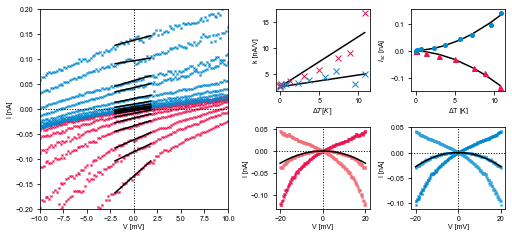

In [703]:
plt.rc('font', **font)

fig_mosaic, ax_mosaic = plt.subplot_mosaic(
    [
        ["IV", "IV","k","Isc"],
        ["IV", "IV","M_L","M_R"]
    ],constrained_layout=True
)



##############
###IV-Curve###
##############

ax_mosaic["IV"].plot(V_sd_exp*1E3, I_exp_G*1E9, 'x', color = (237/255, 20/255, 80/255), ms = 2)
ax_mosaic["IV"].plot(V_sd_exp*1E3, I_exp_S*1E9, 'x', color = (0/255, 137/255, 207/255), ms = 2)


for i in range(len(V_h)):
    ax_mosaic["IV"].plot(V*1E3, (V*k_G[i]+m_G[i])*1E9, 'k')
    ax_mosaic["IV"].plot(V*1E3, (V*k_S[i]+m_S[i])*1E9, 'k')

vline = ax_mosaic["IV"].axvline(x=0, linestyle=':', color='k', linewidth = 1)
hline = ax_mosaic["IV"].axhline(y=0, linestyle=':', color='k', linewidth = 1)
#ax_IV.axvline(x=V_sd[start_G]*1E3,  color='k', linewidth = 1)

ax_mosaic["IV"].set_xlim(-10, 10)
ax_mosaic["IV"].set_ylim(-0.2, 0.2)

ax_mosaic["IV"].set_xlabel('V [mV]', labelpad=2)
ax_mosaic["IV"].set_ylabel('I [nA]', labelpad=2)


#########
### k ###
#########

ax_mosaic["k"].plot(DeltaT_G, G*1E9 + DeltaT_G*H_G*1E9, 'k')
ax_mosaic["k"].plot(DeltaT_S, G*1E9 + DeltaT_S*H_S*1E9, 'k')
ax_mosaic["k"].plot(DeltaT_G, k_G*1E9, 'x', color = (237/255, 20/255, 80/255))
ax_mosaic["k"].plot(DeltaT_S, k_S*1E9, 'x', color = (0/255, 137/255, 207/255))

ax_mosaic["k"].set_xlabel('$\Delta T [K]$', labelpad=2)
ax_mosaic["k"].set_ylabel('k [nA/V]', labelpad=2)


###########
### Isc ###
###########

ax_mosaic["Isc"].plot(DeltaT_G, Isc_poly_G*1E9, 'k')       
ax_mosaic["Isc"].plot(DeltaT_G, Isc_exp_G*1E9, linestyle = 'none', marker = '^', ms = 5, color = (237/255, 20/255, 80/255)) 

ax_mosaic["Isc"].plot(DeltaT_S, Isc_poly_S*1E9, 'k') 
ax_mosaic["Isc"].plot(DeltaT_S, Isc_exp_S*1E9, linestyle = 'none', marker = 'o', ms = 4, color = (0/255, 137/255, 207/255)) 



ax_mosaic["Isc"].set_xlabel('$\Delta$T [K]', labelpad=2)
ax_mosaic["Isc"].set_ylabel('$I_{sc}$ [nA]', labelpad=2)

###########
### M_L ###
###########


ax_mosaic["M_L"].plot(V_sd_exp*1E3, I_exp_G[:,0]*1E9, 'x', color = (237/255, 20/255, 80/255), ms = 2)
ax_mosaic["M_L"].plot(V_sd_exp*1E3, I_exp_G_rev*1E9, 'x', color = (241/255, 112/255, 119/255), ms = 2)
ax_mosaic["M_L"].plot(V_sd_exp*1E3, I_asym_G*1E9, 'x', color = (241/255, 112/255, 119/255), ms = 2)
#polyfit
ax_mosaic["M_L"].plot(V_sd_exp*1E3, I_parabola_S*1E9, 'k')

vline = ax_mosaic["M_L"].axvline(x=0, linestyle=':', color='k', linewidth = 1)
hline = ax_mosaic["M_L"].axhline(y=0, linestyle=':', color='k', linewidth = 1)


ax_mosaic["M_L"].set_xlabel('V [mV]', labelpad=2)
ax_mosaic["M_L"].set_ylabel('I [nA]', labelpad=2)

###########
### M_R ###
###########

ax_mosaic["M_R"].plot(V_sd_exp*1E3, I_exp_S[:,0]*1E9, 'x', color = (0/255, 137/255, 207/255), ms = 2)
ax_mosaic["M_R"].plot(V_sd_exp*1E3, I_exp_S_rev*1E9, 'x', color = (44/255, 161/255, 218/255), ms = 2)
ax_mosaic["M_R"].plot(V_sd_exp*1E3, I_asym_S*1E9, 'x', color = (44/255, 161/255, 218/255), ms = 2)
#polyfit
ax_mosaic["M_R"].plot(V_sd_exp*1E3, I_parabola_S*1E9, 'k')

vline = ax_mosaic["M_R"].axvline(x=0, linestyle=':', color='k', linewidth = 1)
hline = ax_mosaic["M_R"].axhline(y=0, linestyle=':', color='k', linewidth = 1)


ax_mosaic["M_R"].set_xlabel('V [mV]', labelpad=2)
ax_mosaic["M_R"].set_ylabel('I [nA]', labelpad=2)





fig_mosaic.set_size_inches(figwidth_DC_Nature,figwidth_DC_Nature/2.2)

if save_fig == 1:

    fig_mosaic.savefig(savename_fig+'_poly_mosaic.svg')
    fig_mosaic.savefig(savename_fig+'_poly_mosaic.png')

## The resulting polynomial equations

In [704]:
def I_G(V, DeltaT, G=G, L=L, M=M, N=N, H_G=H_G):
    I = G*V+L*DeltaT-M*V**2+N*DeltaT**2+H_G*V*DeltaT
    return I

def I_S(V, DeltaT, G=G, L=L, M=M, N=N, H_S=H_S):
    I = G*V-L*DeltaT-M*V**2-N*DeltaT**2+H_S*V*DeltaT
    return I

In [705]:
V_sd = np.linspace(-20*1E-3, 20*1E-3, 201)
#DeltaT_G
I_poly_G = np.zeros([len(V_sd), len(V_h)])
I_poly_S = np.zeros([len(V_sd), len(V_h)])

for i in range(len(V_h)):
    for j in range(len(V_sd)):
        I_poly_G[j,i] = I_G(V_sd[j], DeltaT_G[i])#, L=np.abs(L_G), N = np.abs(N_G))
        I_poly_S[j,i] = I_S(V_sd[j], DeltaT_S[i])#, L=np.abs(L_S), N = np.abs(N_S))

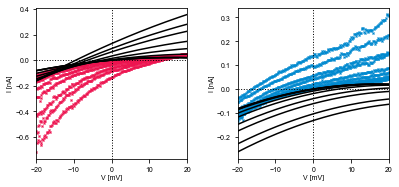

In [706]:
fig, (ax1, ax2) = plt.subplots(1,2)

fig.set_size_inches(figwidth_DC_Nature,figwidth_DC_Nature/2)
ax1.set_position([0.2, 0.2, 0.3, 0.6]) # Manually set "data frame" size: x, y, widht, height in precentage of full window
ax2.set_position([0.6, 0.2, 0.3, 0.6]) # Manually set "data frame" size: x, y, widht, height in precentage of full window


ax1.plot(V_sd_exp*1E3, I_exp_G*1E9, 'x', color = (237/255, 20/255, 80/255), ms = 2)
#ax.plot(V_sd_exp*1E3, I_exp_S*1E9, 'x', color = (0/255, 137/255, 207/255), ms = 2)
ax1.plot(V_sd*1E3, I_poly_G*1E9, 'k')

vline = ax1.axvline(x=0, linestyle=':', color='k', linewidth = 1)
hline = ax1.axhline(y=0, linestyle=':', color='k', linewidth = 1)

ax1.set_xlim(-20, 20)

#ax1.set_title('G  = {:.1e}, '.format(G)+ '$L$  = {:.1e}, '.format(-L) + 'M  = {:.1e}, '.format(-M) + '$N$  = {:.1e}, '.format(-N) +'$H_G$  = {:.1e}'.format(H_G) )
ax1.set_xlabel('V [mV]', labelpad=2)
ax1.set_ylabel('I [nA]', labelpad=2)



ax2.plot(V_sd_exp*1E3, I_exp_S*1E9, 'x', color = (0/255, 137/255, 207/255), ms = 2)
ax2.plot(V_sd*1E3, I_poly_S*1E9, 'k')

vline = ax2.axvline(x=0, linestyle=':', color='k', linewidth = 1)
hline = ax2.axhline(y=0, linestyle=':', color='k', linewidth = 1)

ax2.set_xlim(-20, 20)

#ax2.set_title('G  = {:.1e}, '.format(G)+ '$L$  = {:.1e}, '.format(L) + 'M  = {:.1e}, '.format(-M) + '$N$  = {:.1e}, '.format(N) +'$H_S$  = {:.1e}'.format(H_S) )
ax2.set_xlabel('V [mV]', labelpad=2)
ax2.set_ylabel('I [nA]', labelpad=2)

if save_fig == 1:

    fig.savefig(savename_fig+'_IV_polynomial.svg')
    fig.savefig(savename_fig+'_IV_polynomial.png')


# Additional plots with polynomial model

Equations

In [707]:

def Voc_poly_G(T, G=G, L=L, M=M, N=N, H_G=H_G):
    Voc = (G+H_G*T-np.sqrt((G+H_G*T)**2-4*M*(L*T+N*T**2)))/(-2*M)
    return Voc

def Voc_poly_S(T, G=G, L=L, M=M, N=N, H_S=H_S):
    Voc = (G+H_S*T-np.sqrt((G+H_S*T)**2+4*M*(L*T+N*T**2)))/(-2*M)
    return Voc

def V_max_Poly_G(T, G=G, L=L, M=M, N=N, H_G=H_G):
    Vmax = (G+H_G*T-np.sqrt((G+H_G*T)**2-3*M*(L*T+N*T**2)))/(-3*M)
    return Vmax

def V_max_Poly_S(T, G=G, L=L, M=M, N=N, H_S=H_S):
    Vmax = (G+H_S*T-np.sqrt((G+H_S*T)**2+3*M*(L*T+N*T**2)))/(-3*M)
    return Vmax    
        

def P_max_Poly_G(T, Vm, G=G, L=L, M=M, N=N, H_G=H_G):
    Pmax = (G*Vm+L*T+M*Vm**2+N*T**2+H_G*Vm**T)**Vm
    return Pmax  


def P_max_Poly_S(T, Vm, G=G, L=L, M=M, N=N, H_S=H_S):
    Pmax = (G*Vm-L*T+M*Vm**2-N*T**2+H_S*Vm**T)**Vm
    return Pmax  


## Voc

Calculate

In [708]:
Voc_Poly1_G = Voc_poly_G(DeltaT_model)
Voc_Poly1_S = Voc_poly_S(DeltaT_model)
Voc_linear = L/G*DeltaT_model

Plot

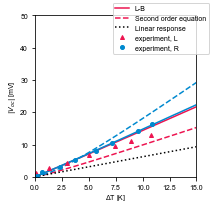

In [709]:
if plot == 1:
    plt.rc('font', **font)          
    fig_Voc2, ax_Voc = plt.subplots()
    ax_Voc.set_position([0.3, 0.3, 0.65, 0.65]) # Manually set "data frame" size: x, y, widht, height in precentage of full window


    #Landauer-Buttiker
    ax_Voc.plot(DeltaT_model, abs(Voc_model_G*1E3), color = (237/255, 20/255, 80/255), label = 'L-B') 
    ax_Voc.plot(DeltaT_model, abs(Voc_model_S*1E3), color = (0/255, 137/255, 207/255)) 
    #Second order
    ax_Voc.plot(DeltaT_model, abs(Voc_Poly1_G*1E3), '--', color = (237/255, 20/255, 80/255), label = 'Second order equation')
    ax_Voc.plot(DeltaT_model, abs(Voc_Poly1_S*1E3), '--', color = (0/255, 137/255, 207/255))
    #Linear response
    ax_Voc.plot(DeltaT_model, Voc_linear*1E3, 'k:', label = 'Linear response')
    #Experiment    
    ax_Voc.plot(DeltaT_G, abs(Voc_exp_G*1E3), '^', ms=4, color = (237/255, 20/255, 80/255), label = 'experiment, L')
    ax_Voc.plot(DeltaT_S, abs(Voc_exp_S*1E3), 'o', ms=4, color = (0/255, 137/255, 207/255), label = 'experiment, R')


    ax_Voc.set_xlim(0, 15)
    #ax_Voc.set_xticks([0, 5, 10, 15])
    ax_Voc.set_ylim(0, 50)
    ax_Voc.set_xlabel('$\Delta$T [K]', labelpad=2)
    ax_Voc.set_ylabel('$|V_{oc}|$ [mV]', labelpad=2)

    fig_Voc2.set_size_inches(figwidth_SC_Nature, figwidth_SC_Nature)
    fig_Voc2.legend()#loc='upper left')

    

    fig_Voc2.savefig(savename_fig+'_Voc4.svg')
    fig_Voc2.savefig(savename_fig+'_Voc4.png')

Ratio

<ipython-input-710-0f6b1ea75a1a>:7: RuntimeWarning: invalid value encountered in true_divide
  ax_Voc.plot(DeltaT_model, abs(Voc_model_G)/(L/G*DeltaT_model), color = (237/255, 20/255, 80/255), label = 'L-B')
<ipython-input-710-0f6b1ea75a1a>:8: RuntimeWarning: invalid value encountered in true_divide
  ax_Voc.plot(DeltaT_model, abs(Voc_model_S)/(L/G*DeltaT_model), color = (0/255, 137/255, 207/255))
<ipython-input-710-0f6b1ea75a1a>:10: RuntimeWarning: invalid value encountered in true_divide
  ax_Voc.plot(DeltaT_model, abs(Voc_Poly1_G)/(L/G*DeltaT_model), '--', color = (237/255, 20/255, 80/255), label = 'Second order equation')
<ipython-input-710-0f6b1ea75a1a>:11: RuntimeWarning: invalid value encountered in true_divide
  ax_Voc.plot(DeltaT_model, abs(Voc_Poly1_S)/(L/G*DeltaT_model), '--', color = (0/255, 137/255, 207/255))


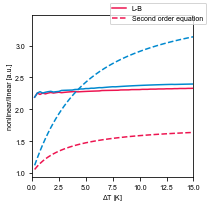

In [710]:
if plot == 1:
    plt.rc('font', **font)          
    fig_Voc2, ax_Voc = plt.subplots()
    ax_Voc.set_position([0.3, 0.3, 0.65, 0.65]) # Manually set "data frame" size: x, y, widht, height in precentage of full window

    #Landauer-Buttiker
    ax_Voc.plot(DeltaT_model, abs(Voc_model_G)/(L/G*DeltaT_model), color = (237/255, 20/255, 80/255), label = 'L-B') 
    ax_Voc.plot(DeltaT_model, abs(Voc_model_S)/(L/G*DeltaT_model), color = (0/255, 137/255, 207/255)) 
    #Second order
    ax_Voc.plot(DeltaT_model, abs(Voc_Poly1_G)/(L/G*DeltaT_model), '--', color = (237/255, 20/255, 80/255), label = 'Second order equation')
    ax_Voc.plot(DeltaT_model, abs(Voc_Poly1_S)/(L/G*DeltaT_model), '--', color = (0/255, 137/255, 207/255))



    ax_Voc.set_xlim(0, 15)
    #ax_Voc.set_xticks([0, 5, 10, 15])
   # ax_Voc.set_ylim(0, 50)
    ax_Voc.set_xlabel('$\Delta$T [K]', labelpad=2)
    ax_Voc.set_ylabel('nonlinear/linear [a.u.]', labelpad=2)
    
    fig_Voc2.set_size_inches(figwidth_SC_Nature, figwidth_SC_Nature)
    fig_Voc2.legend()#loc='upper left')

    

    fig_Voc2.savefig(savename_fig+'_Voc_ratio.svg')
    fig_Voc2.savefig(savename_fig+'_Voc_ratio.png')

## I_sc

Calculate

In [711]:
Isc_Poly_G = L*DeltaT_model+N*DeltaT_model**2
Isc_Poly_S = -L*DeltaT_model-N*DeltaT_model**2

Isc_linear = L*DeltaT_model

Plot

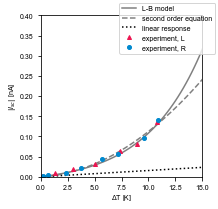

In [712]:
if plot == 1:
      
    fig_Isc, ax_Isc = plt.subplots()
    ax_Isc.set_position([0.3, 0.3, 0.65, 0.65]) # Manually set "data frame" size: x, y, widht, height in precentage of full window

    ### Voc ###
    #L_B model
    ax_Isc.plot(DeltaT_model, abs(Isc_model_G*1E9), 'gray', label = 'L-B model')
    #ax_Isc.plot(DeltaT_model, abs(Isc_model_S*1E9), color = (0/255, 137/255, 207/255))
    # Polynomial
    ax_Isc.plot(DeltaT_model, abs(Isc_Poly_G*1E9),'gray', linestyle = 'dashed', label = 'second order equation')
    #ax_Isc.plot(DeltaT_model, abs(Isc_Poly_S*1E9), '--',color = (0/255, 137/255, 207/255))

    #Linear response
    ax_Isc.plot(DeltaT_model, abs(Isc_linear*1E9), ':k', label = 'linear response')
    #Experiment
    ax_Isc.plot(DeltaT_G, abs(Isc_exp_G*1E9), '^', ms=4, color = (237/255, 20/255, 80/255), label = 'experiment, L')
    ax_Isc.plot(DeltaT_S, abs(Isc_exp_S*1E9), 'o', ms=4, color = (0/255, 137/255, 207/255), label = 'experiment, R')


    ax_Isc.set_xlabel('$\Delta$T [K]', labelpad=2)
    ax_Isc.set_ylabel('$|I_{sc}|$ [nA]', labelpad=2)
    ax_Isc.set_xlim(0,15)

    ax_Isc.set_ylim(0, 0.4)


    fig_Isc.set_size_inches(figwidth_SC_Nature, figwidth_SC_Nature)
    fig_Isc.legend()#loc='upper left')

    fig_Isc.savefig(savename_fig+'_Isc2.svg')
    fig_Isc.savefig(savename_fig+'_Isc2.png')

Ratio

<ipython-input-713-f28332547333>:8: RuntimeWarning: invalid value encountered in true_divide
  ax_Isc.plot(DeltaT_model, abs(Isc_model_G)/abs(Isc_linear), 'gray', label = 'L-B model')
<ipython-input-713-f28332547333>:11: RuntimeWarning: invalid value encountered in true_divide
  ax_Isc.plot(DeltaT_model, abs(Isc_Poly_G)/abs(Isc_linear),'gray', linestyle = 'dashed', label = 'second order equation')


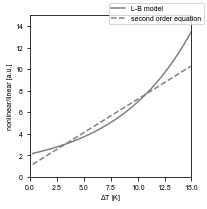

In [713]:
if plot == 1:
      
    fig_Isc, ax_Isc = plt.subplots()
    ax_Isc.set_position([0.3, 0.3, 0.65, 0.65]) # Manually set "data frame" size: x, y, widht, height in precentage of full window

    ### Voc ###
    #L_B model
    ax_Isc.plot(DeltaT_model, abs(Isc_model_G)/abs(Isc_linear), 'gray', label = 'L-B model')
    #ax_Isc.plot(DeltaT_model, abs(Isc_model_S*1E9), color = (0/255, 137/255, 207/255))
    # Polynomial
    ax_Isc.plot(DeltaT_model, abs(Isc_Poly_G)/abs(Isc_linear),'gray', linestyle = 'dashed', label = 'second order equation')
    #ax_Isc.plot(DeltaT_model, abs(Isc_Poly_S*1E9), '--',color = (0/255, 137/255, 207/255))

    ax_Isc.set_xlabel('$\Delta$T [K]', labelpad=2)
    ax_Isc.set_ylabel('nonlinear/linear [a.u.]', labelpad=2)
    ax_Isc.set_xlim(0,15)

    ax_Isc.set_ylim(0, 15)


    fig_Isc.set_size_inches(figwidth_SC_Nature, figwidth_SC_Nature)
    fig_Isc.legend()#loc='upper left')

    fig_Isc.savefig(savename_fig+'_Isc_ratio.svg')
    fig_Isc.savefig(savename_fig+'_Isc_ratio.png')

## Pmax

Calculate

In [714]:
Vm_Poly_G = V_max_Poly_G(DeltaT_model)
Vm_Poly_S = V_max_Poly_S(DeltaT_model)


Pm_Poly_G = (G*Vm_Poly_G+L*DeltaT_model+M*Vm_Poly_G**2+N*DeltaT_model**2+H_G*Vm_Poly_G**DeltaT_model)**Vm_Poly_G

#Pm_Poly_G = P_max_Poly_G(DeltaT_model, Vm_Poly_G)
#Pm_Poly_S = P_max_Poly_S(DeltaT_model, Vm_Poly_S)

#P_max_Poly_G = abs(I_G(Vm_Poly_G, DeltaT_model)*Vm_Poly_G)
#P_max_Poly_S = abs(I_S(Vm_Poly_S, DeltaT_model)*Vm_Poly_S)

P_max_linear = 1/4*L**2/G*DeltaT_model**2

<ipython-input-714-b6336ec5da33>:5: RuntimeWarning: invalid value encountered in power
  Pm_Poly_G = (G*Vm_Poly_G+L*DeltaT_model+M*Vm_Poly_G**2+N*DeltaT_model**2+H_G*Vm_Poly_G**DeltaT_model)**Vm_Poly_G


In [715]:
G*Vm_Poly_G+L*DeltaT_model+M*Vm_Poly_G**2+N*DeltaT_model**2+H_G*Vm_Poly_G**DeltaT_model

<ipython-input-715-21def07daef9>:1: RuntimeWarning: invalid value encountered in power
  G*Vm_Poly_G+L*DeltaT_model+M*Vm_Poly_G**2+N*DeltaT_model**2+H_G*Vm_Poly_G**DeltaT_model


array([9.66804752e-10,            nan,            nan,            nan,
       1.25794772e-12,            nan,            nan,            nan,
       5.02251755e-12,            nan,            nan,            nan,
       1.03183096e-11,            nan,            nan,            nan,
       1.75423559e-11,            nan,            nan,            nan,
       2.67137945e-11,            nan,            nan,            nan,
       3.78436474e-11,            nan,            nan,            nan,
       5.09385557e-11,            nan,            nan,            nan,
       6.60027649e-11,            nan,            nan,            nan,
       8.30391177e-11,            nan,            nan,            nan,
       1.02049590e-10,            nan,            nan,            nan,
       1.23035599e-10,            nan,            nan,            nan,
       1.45998186e-10,            nan,            nan,            nan,
       1.70938135e-10,            nan,            nan,            nan,
      

In [716]:
P_max_Wu = 30*1/4*10**-15*DeltaT_model**2
P_max_Chen = 0.2*1/4*10**-15*DeltaT_model**2
P_max_Roddaro = 11*1/4*10**-15*DeltaT_model**2

Plot

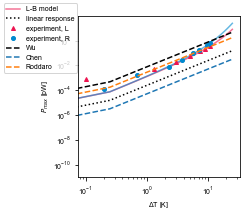

In [717]:
if plot == 1:
      
    fig_Pmax, ax_Pmax = plt.subplots()
    ax_Pmax.set_position([0.3, 0.3, 0.65, 0.65]) # Manually set "data frame" size: x, y, widht, height in precentage of full window

    
    #L_B model
    ax_Pmax.plot(DeltaT_model, P_max_model_G*1E12, color = (237/255, 20/255, 80/255), alpha = 0.6, label = 'L-B model')
    ax_Pmax.plot(DeltaT_model, P_max_model_S*1E12, color = (0/255, 137/255, 207/255), alpha = 0.6)

    # Polynomial
    #ax_Pmax.plot(DeltaT_model, P_max_Poly_G*1E12, '--', color = (237/255, 20/255, 80/255), alpha = 0.6, label = 'second order equation')
    #ax_Pmax.plot(DeltaT_model, P_max_Poly_S*1E12, '--', color = (0/255, 137/255, 207/255), alpha = 0.6)
    # Linear response
    ax_Pmax.plot(DeltaT_model, P_max_linear*1E12, 'k:', label = 'linear response')
    #Experiment
    ax_Pmax.plot(DeltaT_G, P_max_exp_G*1E12, '^', ms=4, color = (237/255, 20/255, 80/255), label = 'experiment, L')
    ax_Pmax.plot(DeltaT_S, P_max_exp_S*1E12, 'o', ms=4, color = (0/255, 137/255, 207/255), label = 'experiment, R')

    #From Philip Wu's data
    ax_Pmax.plot(DeltaT_model, P_max_Wu*1E12, 'k--', label = 'Wu')
    ax_Pmax.plot(DeltaT_model, P_max_Chen*1E12, '--', label = 'Chen')
    ax_Pmax.plot(DeltaT_model, P_max_Roddaro*1E12, '--', label = 'Roddaro')
    #hline = ax_Pmax.axhline(y=0.75, linestyle='--', color='k', linewidth = 1, label = 'Wu')

    ax_Pmax.set_xlabel('$\Delta$T [K]', labelpad=2)
    ax_Pmax.set_ylabel('$P_{max}$ [pW]', labelpad=2)

    #ax_Pmax.set_xlim(0,15)
    ax_Pmax.set_xscale('log')
    ax_Pmax.set_yscale('log')
    #ax_Pmax.set_xticks([0,5,10,15])
    #ax_Pmax.set_ylim(0, 2)
   # ax_Pmax.set_yticks([0, 1])

    fig_Pmax.set_size_inches(figwidth_SC_Nature, figwidth_SC_Nature)
    fig_Pmax.legend(loc='upper left')

    fig_Pmax.savefig(savename_fig+'_Pmax3_log.svg')
    fig_Pmax.savefig(savename_fig+'_Pmax3_log.png')

ratio

<ipython-input-721-befcc9518112>:8: RuntimeWarning: invalid value encountered in true_divide
  ax_Pmax.plot(DeltaT_model, P_max_model_G/P_max_linear, color = (237/255, 20/255, 80/255), alpha = 0.6, label = 'L-B, L')
<ipython-input-721-befcc9518112>:9: RuntimeWarning: invalid value encountered in true_divide
  ax_Pmax.plot(DeltaT_model, P_max_model_S/P_max_linear, color = (0/255, 137/255, 207/255), alpha = 0.6, label = 'L-B, R')


TypeError: unsupported operand type(s) for /: 'function' and 'float'

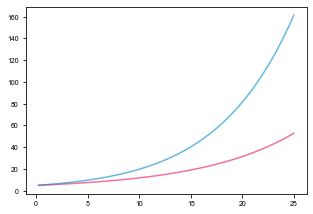

In [721]:
if plot == 1:
      
    fig_Pmax, ax_Pmax = plt.subplots()
    ax_Pmax.set_position([0.3, 0.3, 0.65, 0.65]) # Manually set "data frame" size: x, y, widht, height in precentage of full window

    
    #L_B model
    ax_Pmax.plot(DeltaT_model, P_max_model_G/P_max_linear, color = (237/255, 20/255, 80/255), alpha = 0.6, label = 'L-B, L')
    ax_Pmax.plot(DeltaT_model, P_max_model_S/P_max_linear, color = (0/255, 137/255, 207/255), alpha = 0.6, label = 'L-B, R')

    # Polynomial
    ax_Pmax.plot(DeltaT_model, P_max_Poly_G/P_max_linear, '--', color = (237/255, 20/255, 80/255), alpha = 0.6, label = 'second order equation, L')
    ax_Pmax.plot(DeltaT_model, P_max_Poly_S/P_max_linear, '--', color = (0/255, 137/255, 207/255), alpha = 0.6, label = 'second order equation, R')

    

    ax_Pmax.set_xlabel('$\Delta$T [K]', labelpad=2)
    ax_Pmax.set_ylabel('nonlinear/linear [a.u.]', labelpad=2)

    ax_Pmax.set_xlim(0,15)
    #ax_Pmax.set_xticks([0,5,10,15])
    ax_Pmax.set_ylim(0, 50)
   # ax_Pmax.set_yticks([0, 1])

    fig_Pmax.set_size_inches(figwidth_SC_Nature, figwidth_SC_Nature)
    fig_Pmax.legend()
    fig_Pmax.savefig(savename_fig+'_Pmax_ratio.svg')
    fig_Pmax.savefig(savename_fig+'_Pmax_ratio.png')

## FF

In [ ]:
FF_poly1_G = 1/4 - M*L*DeltaT_model/(8*G**2)
FF_poly1_S = 1/4 + M*L*DeltaT_model/(8*G**2)

FF_poly2_G = P_max_Poly_G/abs(Isc_Poly_G*Voc_Poly1_G)   #The first value is 0 so can't devide by it, = nan
FF_poly2_S = P_max_Poly_S/abs(Isc_Poly_S*Voc_Poly1_S)

#FF_poly2_G = 2*(np.sqrt(H_G**2+3*M*N)-H_G)*(6*M*N+H_G*(np.sqrt(H_G**2+3*M*N)-H_G))/(27*M**2*(np.sqrt(H_G**2+4*M*N)-H_G))
#FF_poly2_S = 2*(np.sqrt(H_S**2-3*M*N)-H_S)#*(-6*M*N+H_S*(np.sqrt(H_S**2-3*M*N)-H_S))#/(27*M**2*(np.sqrt(H_S**2-4*M*N)-H_S))


<ipython-input-258-c432ea78a3cb>:4: RuntimeWarning: invalid value encountered in true_divide
  FF_poly2_G = P_max_Poly_G/abs(Isc_Poly_G*Voc_Poly1_G)   #The first value is 0 so can't devide by it, = nan
<ipython-input-258-c432ea78a3cb>:5: RuntimeWarning: invalid value encountered in true_divide
  FF_poly2_S = P_max_Poly_S/abs(Isc_Poly_S*Voc_Poly1_S)


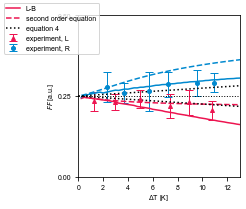

In [ ]:

    
fig_FF, ax_FF = plt.subplots()
ax_FF.set_position([0.3, 0.3, 0.65, 0.65]) # Manually set "data frame" size: x, y, widht, height in precentage of full window

ax_FF.errorbar(DeltaT_G[3:], FF_exp_G[3:], FF_std_G[3:], linestyle = 'none', marker = '^', ms = 4, elinewidth = 1, capsize=4, color = (237/255, 20/255, 80/255), label = 'experiment, L')
ax_FF.errorbar(DeltaT_S[3:], FF_exp_S[3:], FF_std_S[3:], linestyle = 'none', marker = 'o', ms = 4, elinewidth = 1, capsize=4, color = (0/255, 137/255, 207/255), label = 'experiment, R')

ax_FF.plot(DeltaT_model, FF_model_G, color = (237/255, 20/255, 80/255), label = 'L-B')
ax_FF.plot(DeltaT_model, FF_model_S, color = (0/255, 137/255, 207/255))

ax_FF.plot(DeltaT_model, FF_poly2_G, '--', color = (237/255, 20/255, 80/255), label = 'second order equation')
ax_FF.plot(DeltaT_model, FF_poly2_S, '--', color = (0/255, 137/255, 207/255))

ax_FF.plot(DeltaT_model, FF_poly1_G, ':k', label = 'equation 4')
ax_FF.plot(DeltaT_model, FF_poly1_S, ':k')




hline = ax_FF.axhline(y=0.25, linestyle=':', color='k', linewidth = 1)

ax_FF.set_xlabel('$\Delta$T [K]', labelpad=2)
ax_FF.set_ylabel('$FF$ [a.u.]', labelpad=2)
ax_FF.set_xlim(0, 13)
ax_FF.set_ylim(0, 0.5)
ax_FF.set_yticks([0, 0.25, 0.5])
fig_FF.set_size_inches(figwidth_SC_Nature, figwidth_SC_Nature)
fig_FF.legend(loc='upper left')

fig_FF.savefig(savename_fig+'_FF2.svg')
fig_FF.savefig(savename_fig+'_FF2.png')

if save_fig == 1:

    fig_FF.savefig(savename_fig+'_FF_poly_Gneg.svg')
    fig_FF.savefig(savename_fig+'_FF_poly_Gneg.png')

# The final plot of all results in a mosaic

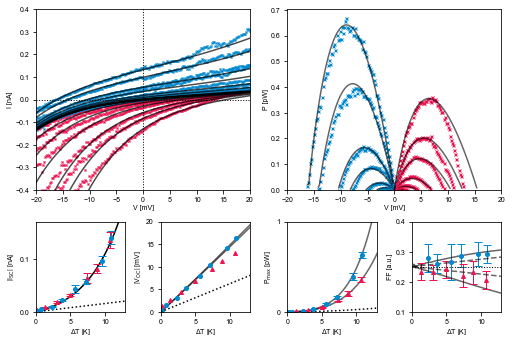

In [724]:
plt.rc('font', **font)

fig_mosaic, ax_mosaic = plt.subplot_mosaic(
    [
        ["IV", "IV","P","P"],
        ["IV", "IV","P","P"],
        ["Isc", "Voc", "Pmax", "FF"],
    ],constrained_layout=True
)



##############
###IV-Curve###
##############

ax_mosaic["IV"].plot(V_sd_exp*1E3, I_exp_G*1E9, 'x', color = (237/255, 20/255, 80/255), ms = 2)
ax_mosaic["IV"].plot(V_sd_exp*1E3, I_exp_S*1E9, 'x', color = (0/255, 137/255, 207/255), ms = 2)

ax_mosaic["IV"].plot(V_sd_exp*1E3, I_fit_G*1E9, 'k', alpha = 0.7)
ax_mosaic["IV"].plot(V_sd_exp*1E3, I_fit_S*1E9, 'k', alpha = 0.7)

vline = ax_mosaic["IV"].axvline(x=0, linestyle=':', color='k', linewidth = 1)
hline = ax_mosaic["IV"].axhline(y=0, linestyle=':', color='k', linewidth = 1)
#ax_IV.axvline(x=V_sd[start_G]*1E3,  color='k', linewidth = 1)

ax_mosaic["IV"].set_xlim(-20, 20)
ax_mosaic["IV"].set_ylim(-0.4, 0.4)

ax_mosaic["IV"].set_xlabel('V [mV]', labelpad=2)
ax_mosaic["IV"].set_ylabel('I [nA]', labelpad=2)

###########
###Power###
###########


for i in range(len(V_h)):
        
    ax_mosaic["P"].plot(V_exp_cut_G[i]*1E3, P_exp_cut_G[i]*1E12, 'x',color = (237/255, 20/255, 80/255), label = 'gradient side', ms=3)
    ax_mosaic["P"].plot(-V_exp_cut_S[i]*1E3, P_exp_cut_S[i]*1E12, 'x', color = (0/255, 137/255, 207/255), label = 'steep side', ms=3)

    ax_mosaic["P"].plot(V_fit_cut_G[i]*1E3, P_fit_cut_G[i]*1E12, 'k', alpha = 0.6, label = 'fit gradient side')
    ax_mosaic["P"].plot(-V_fit_cut_S[i]*1E3, P_fit_cut_S[i]*1E12,  'k', alpha = 0.6, label = 'fit steep side')
    
        #Plot standard deviation
    #common_index_G = np.nonzero(np.in1d(V_exp_cut_G[i], V_exp_cut_G_std[i]))[0]
    #common_index_S = np.nonzero(np.in1d(V_exp_cut_S[i], V_exp_cut_S_std[i]))[0]


    #plt.fill_between(V_exp_cut_G_std[i]*1E3, (P_exp_cut_G[i][common_index_G]+P_exp_cut_G_std[i])*1E12, (P_exp_cut_G[i][common_index_G]-P_exp_cut_G_std[i])*1E12, color = (237/255, 20/255, 80/255), alpha=0.4) 
    #plt.fill_between(V_exp_cut_S_std[i]*1E3, (P_exp_cut_S[i][common_index_S]+P_exp_cut_S_std[i])*1E12, (P_exp_cut_S[i][common_index_S]-P_exp_cut_S_std[i])*1E12, color = (237/255, 20/255, 80/255), alpha=0.4) 

    ###If you want to plot black marks to indicate maximas 
    #if P_exp_cut_G[i].size != 1:
    #    ax_mosaic["P"].plot(V_cut_poly_G[i][find_nearest(abs(P_cut_poly_G[i]), P_max_poly_G[i])]*1E3, P_max_poly_G[i]*1E12,  'xk')
    #    ax_mosaic["P"].plot(-V_cut_poly_S[i][find_nearest(abs(P_cut_poly_S[i]), P_max_poly_S[i])]*1E3, P_max_poly_S[i]*1E12,  'xk')

    
    

ax_mosaic["P"].set_xlabel('V [mV]', labelpad=2)
ax_mosaic["P"].set_ylabel('P [pW]', labelpad=2)
ax_mosaic["P"].set_xlim(-20, 20)
ax_mosaic["P"].set_ylim(0)

##########################
###open-circuit voltage###
##########################

#Landauer-Buttiker model
ax_mosaic["Voc"].plot(DeltaT_model, abs(Voc_model_G*1E3), 'k', alpha = 0.6, label = 'model') 
ax_mosaic["Voc"].plot(DeltaT_model, abs(Voc_model_S*1E3), 'k', alpha = 0.6, label = 'model') 
#Experiment
ax_mosaic["Voc"].plot(DeltaT_G, abs(Voc_exp_G*1E3), '^', ms=4, color = (237/255, 20/255, 80/255), label = 'gradient side')
ax_mosaic["Voc"].plot(DeltaT_S, abs(Voc_exp_S*1E3), 'o', ms=4, color = (0/255, 137/255, 207/255), label = 'steep side')
#Linear response
ax_mosaic["Voc"].plot(DeltaT_model, Voc_linear*1E3, 'k:', label = 'linear response')

ax_mosaic["Voc"].set_xlim(0,13)
#ax_Voc.set_xticks([0, 5, 10, 15])
ax_mosaic["Voc"].set_ylim(0, 20)
ax_mosaic["Voc"].set_xlabel('$\Delta$T [K]', labelpad=2)
ax_mosaic["Voc"].set_ylabel('|V$_\mathrm{OC}$| [mV]', labelpad=2)

###########################
###short-circuit current###
###########################
#Landauer-Buttiker model
ax_mosaic["Isc"].plot(DeltaT_model, abs(Isc_model_G*1E9), 'k', label = 'model') 
#Experiment
ax_mosaic["Isc"].errorbar(DeltaT_G, abs(Isc_exp_G*1E9), Isc_std_G*1E9, linestyle = 'none', marker = '^', ms = 4, elinewidth = 1, capsize=4, color = (237/255, 20/255, 80/255), label = 'gradient side')
ax_mosaic["Isc"].errorbar(DeltaT_S, abs(Isc_exp_S*1E9), Isc_std_S*1E9, linestyle = 'none', marker = 'o', ms = 4, elinewidth = 1, capsize=4, color = (0/255, 137/255, 207/255), label = 'steep side')
#Linear response
ax_mosaic["Isc"].plot(DeltaT_model, abs(Isc_linear*1E9), ':k', label = 'linear response')

ax_mosaic["Isc"].set_xlabel('$\Delta$T [K]', labelpad=2)
ax_mosaic["Isc"].set_ylabel('|I$_\mathrm{SC}$| [nA]', labelpad=2)
ax_mosaic["Isc"].set_xlim(0,13)
ax_mosaic["Isc"].set_xticks([0, 5, 10])
ax_mosaic["Isc"].set_ylim(0, 0.17)
ax_mosaic["Isc"].set_yticks([0, 0.1])

#################
###Fill factor###
#################

ax_mosaic["FF"].plot(DeltaT_model, FF_model_G, 'k', alpha = 0.6, label = 'model gradient side')
ax_mosaic["FF"].plot(DeltaT_model, FF_model_S, 'k', alpha = 0.6, label = 'model steep side')

ax_mosaic["FF"].plot(DeltaT_model, FF_poly1_G, 'k--', alpha = 0.6, label = 'second order')
ax_mosaic["FF"].plot(DeltaT_model, FF_poly1_S, 'k--', alpha = 0.6)



ax_mosaic["FF"].errorbar(DeltaT_G[3:], FF_exp_G[3:], FF_std_G[3:], linestyle = 'none', marker = '^', ms = 4, elinewidth = 1, capsize=4, color = (237/255, 20/255, 80/255), label = 'gradient side')
ax_mosaic["FF"].errorbar(DeltaT_S[3:], FF_exp_S[3:], FF_std_S[3:], linestyle = 'none', marker = 'o', ms = 4, elinewidth = 1, capsize=4, color = (0/255, 137/255, 207/255), label = 'steep side')

hline = ax_mosaic["FF"].axhline(y=0.25, linestyle=':', color='k', linewidth = 1)

ax_mosaic["FF"].set_xlabel('$\Delta$T [K]', labelpad=2)
ax_mosaic["FF"].set_ylabel('FF [a.u.]', labelpad=2)
ax_mosaic["FF"].set_xlim(0, 13)
ax_mosaic["FF"].set_ylim(0.1, 0.4)
#ax_mosaic["FF"].set_yticks([0, 0.25, 0.5])

###############
###Max power###
###############
ax_mosaic["Pmax"].plot(DeltaT_model, P_max_model_G*1E12, 'k', alpha = 0.6)
ax_mosaic["Pmax"].plot(DeltaT_model, P_max_model_S*1E12, 'k', alpha = 0.6)

ax_mosaic["Pmax"].errorbar(DeltaT_G, P_max_poly_G*1E12, P_max_std_G*1E12, linestyle = 'none', marker = '^', ms = 4, elinewidth = 1, capsize=4, color = (237/255, 20/255, 80/255), label = 'gradient side')
ax_mosaic["Pmax"].errorbar(DeltaT_S, P_max_poly_S*1E12, P_max_std_S*1E12, linestyle = 'none', marker = 'o', ms = 4, elinewidth = 1, capsize=4, color = (0/255, 137/255, 207/255), label = 'steep side')

ax_mosaic["Pmax"].plot(DeltaT_model, P_max_linear*1E12, 'k:', label = 'linear response')

    
ax_mosaic["Pmax"].set_xlabel('$\Delta$T [K]', labelpad=2)
ax_mosaic["Pmax"].set_ylabel('P$_{\mathrm{max}}$ [pW]', labelpad=2)

ax_mosaic["Pmax"].set_xlim(0,13)
#ax_Pmax.set_xticks([0,5,10,15])
ax_mosaic["Pmax"].set_ylim(0, 1)
ax_mosaic["Pmax"].set_yticks([0, 1])

#ax_mosaic["Pmax"].text(0.0, 1.0, 'f)', verticalalignment='top')

fig_mosaic.set_size_inches(figwidth_DC_Nature,figwidth_DC_Nature/1.5)

save_fig = 1
if save_fig == 1:

    fig_mosaic.savefig(savename_fig+'_mosaic_linear.svg')
    fig_mosaic.savefig(savename_fig+'_mosaic_linear.png')